Install dependencies

In [1]:
!pip3 install torch torchvision torchaudio
!pip3 install matplotlib
!pip3 install ultralytics roboflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
from ultralytics import YOLO
from pathlib import Path
import os
import json
import yaml


In [3]:

device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device} ({'GPU' if device != 'cpu' else 'CPU'})")


Using device: cuda:0 (GPU)


In [ ]:

CONFIG = {
    'model': 'yolo11m.pt',  # Choose model size: n, s, m, l, x
    'data': 'datasets/dataset_v1/data.yaml',  
    'epochs': 85,
    'batch': 2 if device != 'cpu' else 4,  # Adjust batch 
    'imgsz': 640,
    'patience': 20,
    'device': device, 
}
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [5]:

save_dir = Path('runs/detect')
save_dir.mkdir(parents=True, exist_ok=True)

this_path = os.getcwd()

os.environ['ULTRALYTICS_CONFIG_DIR'] = this_path

data_file = f'{this_path}/{CONFIG['data']}'
with open(data_file, 'r') as f:
    data = yaml.safe_load(f)
    

data['train'] = f'{this_path}/{CONFIG['data'].rsplit('/', 1)[0]}/train/images'
data['val'] = f'{this_path}/{CONFIG['data'].rsplit('/', 1)[0]}/valid/images'
data['test'] = f'{this_path}/{CONFIG['data'].rsplit('/', 1)[0]}/test/images'

with open(data_file, 'w') as f:
    yaml.safe_dump(data, f)


In [6]:

model = YOLO(CONFIG['model'])

In [7]:

results = model.train(
    data=CONFIG['data'],
    epochs=CONFIG['epochs'],
    batch=CONFIG['batch'],
    imgsz=CONFIG['imgsz'],
    patience=CONFIG['patience'],
    device=CONFIG['device'],
    
    verbose=True,
    
    optimizer='SGD',
    lr0=0.001,
    lrf=0.005,
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_bias_lr=0.01,
    warmup_momentum=0.8,
    amp=False,
    
    # Augmentations
    augment=True,
    hsv_h=0.015,  # Image HSV-Hue augmentationc
    hsv_s=0.7,   # Image HSV-Saturation augmentation
    hsv_v=0.4,   # Image HSV-Value augmentation
    degrees=10,  # Image rotation (+/- deg)
    translate=0.1,  # Image translation (+/- fraction)
    scale=0.3,   # Image scale (+/- gain)
    shear=0.0,   # Image shear (+/- deg)
    perspective=0.0,  # Image perspective
    flipud=0.1,  # Image flip up-down
    fliplr=0.1,  # Image flip left-right
    mosaic=1.0,  # Image mosaic
    mixup=0.0,   # Image mixup
    
)


Ultralytics 8.3.35 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 3721MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/dataset_v1/data.yaml, epochs=100, time=None, patience=20, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning /var/home/larizmen/DATA/REPOS/ai-apps/dev/safety-hat/datasets/dataset_v1/train/labels.cache... 1191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1191/1191 [00:00<?, ?it/s]
val: Scanning /var/home/larizmen/DATA/REPOS/ai-apps/dev/safety-hat/datasets/dataset_v1/valid/labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.35G      2.085      4.142      2.127          3        640: 100%|██████████| 596/596 [05:43<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]


                   all         90        635       0.29      0.109      0.104     0.0594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.35G      1.842      2.976      1.902          3        640: 100%|██████████| 596/596 [05:39<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.53it/s]

                   all         90        635       0.75      0.264      0.309      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.36G      1.752      2.453      1.806         22        640: 100%|██████████| 596/596 [05:37<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.58it/s]

                   all         90        635      0.627      0.382      0.454      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.35G      1.678      2.116      1.737         36        640: 100%|██████████| 596/596 [55:06<00:00,  5.55s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:21<00:00,  1.08it/s]

                   all         90        635      0.636      0.461      0.511      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.36G      1.641      2.021      1.697          8        640: 100%|██████████| 596/596 [05:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.635      0.532      0.561      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.36G      1.604      1.819      1.654          9        640: 100%|██████████| 596/596 [05:32<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.619      0.543      0.559       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.35G      1.581      1.697       1.62          2        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all         90        635      0.724      0.545      0.603      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.36G      1.582      1.651      1.604         18        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.646      0.589      0.605      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.36G      1.547      1.579      1.594          7        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635       0.73      0.564      0.624      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.33G       1.53      1.502      1.571         36        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.709      0.584      0.631      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.36G      1.513      1.475      1.588         18        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635       0.69      0.601       0.64      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.35G      1.475      1.409      1.551          7        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.729      0.602      0.657      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.36G      1.476      1.385      1.542         12        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all         90        635      0.743      0.618      0.666      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.35G      1.464      1.344      1.525          5        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all         90        635      0.748      0.615      0.659      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.52G      1.475      1.368      1.523         72        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.736        0.6      0.658      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.35G      1.461       1.31      1.521          5        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.733      0.631      0.649      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.35G      1.432       1.29        1.5          6        640: 100%|██████████| 596/596 [05:37<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.16it/s]


                   all         90        635      0.733      0.604      0.644      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.33G      1.422      1.249      1.499          4        640: 100%|██████████| 596/596 [05:58<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]


                   all         90        635      0.713      0.627      0.648       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.36G       1.42      1.241      1.487         12        640: 100%|██████████| 596/596 [05:55<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all         90        635      0.714      0.617      0.656       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.35G      1.387       1.23      1.472          6        640: 100%|██████████| 596/596 [05:37<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all         90        635      0.729      0.618      0.666       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G      1.375      1.199      1.465          7        640: 100%|██████████| 596/596 [05:37<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635       0.73      0.606      0.657      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.52G      1.353      1.181      1.456          8        640: 100%|██████████| 596/596 [05:39<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]


                   all         90        635      0.744      0.621      0.662       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.35G      1.371      1.155      1.447          3        640: 100%|██████████| 596/596 [05:46<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]

                   all         90        635      0.811      0.588      0.669      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.35G      1.355      1.146      1.455         11        640: 100%|██████████| 596/596 [05:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all         90        635      0.752      0.629      0.692      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.35G      1.325      1.087      1.431         40        640: 100%|██████████| 596/596 [05:49<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]

                   all         90        635      0.797      0.615      0.684      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.33G      1.334      1.098       1.42         14        640: 100%|██████████| 596/596 [05:47<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.40it/s]

                   all         90        635      0.782      0.629      0.695      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.35G      1.301      1.087      1.407         52        640: 100%|██████████| 596/596 [05:47<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.40it/s]

                   all         90        635      0.798      0.636      0.696      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.35G      1.317      1.072      1.418          5        640: 100%|██████████| 596/596 [05:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]


                   all         90        635      0.747      0.651      0.684      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.35G      1.288      1.052       1.41         37        640: 100%|██████████| 596/596 [05:46<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]

                   all         90        635      0.765      0.647      0.683      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.52G      1.275      1.052      1.404          4        640: 100%|██████████| 596/596 [05:47<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]

                   all         90        635      0.797      0.617      0.674      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.35G      1.267      1.022      1.387          3        640: 100%|██████████| 596/596 [05:47<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.41it/s]

                   all         90        635      0.788      0.638      0.687      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.36G      1.267      1.025      1.388         22        640: 100%|██████████| 596/596 [05:48<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]


                   all         90        635       0.76      0.649      0.701      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.36G      1.252       1.01      1.359         23        640: 100%|██████████| 596/596 [05:56<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all         90        635      0.769      0.636      0.704       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.33G      1.246      1.005      1.366         14        640: 100%|██████████| 596/596 [05:37<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.804      0.637      0.699      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.36G       1.23     0.9884      1.362         25        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.773      0.628      0.694      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.36G      1.241      1.007      1.371         21        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.781      0.642      0.699      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.36G      1.229     0.9995      1.352         17        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.799      0.625      0.695      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.35G       1.21      0.956      1.341          5        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.811      0.649      0.704      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.35G      1.223      0.971      1.351         10        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635       0.79      0.664      0.683      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.35G      1.208     0.9462       1.34         43        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.793      0.636      0.692        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.52G      1.191     0.9422      1.331         14        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.734      0.668      0.691      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.33G       1.18     0.9253      1.329         12        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.801      0.632      0.699      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.36G      1.171     0.9139       1.33         20        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.805      0.629      0.692      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.35G      1.162     0.8983      1.312          6        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all         90        635      0.785      0.655      0.697      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.52G      1.158      0.892       1.31          5        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.758      0.644      0.688      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.52G      1.136     0.8829      1.298          5        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.793      0.631        0.7      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.52G      1.146     0.8957      1.296          8        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.815      0.616      0.688      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.35G      1.152      0.877      1.299          8        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]

                   all         90        635      0.818      0.632       0.69      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.35G      1.148     0.8775      1.293         11        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.803      0.626      0.695      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.33G       1.14     0.8703       1.31          7        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.817      0.626      0.703      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.36G      1.126     0.8551      1.288         13        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.765      0.652      0.695      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G      1.118     0.8583       1.29         12        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635       0.79      0.641      0.694      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.36G       1.12     0.8432      1.291         13        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.808      0.611      0.688      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.35G       1.11     0.8394      1.278          8        640: 100%|██████████| 596/596 [05:36<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635        0.8      0.612      0.692      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.35G      1.101     0.8292      1.281          6        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.65it/s]

                   all         90        635      0.794      0.639      0.694      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.35G      1.104     0.8368      1.271          5        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.799      0.633      0.695      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.36G       1.12      0.853      1.291         23        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.818      0.615      0.679      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.33G      1.086     0.8223      1.267         38        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.802      0.637      0.684      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.36G      1.095     0.8057      1.254         20        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.817      0.627      0.682      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.35G      1.096     0.8232      1.267          2        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635       0.85       0.63      0.692      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.35G      1.093     0.8252      1.282          3        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.792      0.639      0.686      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G      1.095     0.8015      1.257          4        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.838      0.615      0.683      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.35G      1.092     0.8251      1.259          5        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.866      0.609       0.69      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.35G      1.082     0.7994      1.257         11        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]

                   all         90        635       0.82      0.617      0.687      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.35G      1.084     0.8119      1.265         10        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.814      0.643      0.698      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.33G      1.077     0.8007      1.242         49        640: 100%|██████████| 596/596 [05:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.811      0.646      0.699      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.36G      1.075     0.8196      1.266         21        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635       0.81      0.611      0.687      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.35G      1.067     0.7899      1.246         10        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.785       0.64      0.695      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.35G      1.056     0.7801      1.234          7        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.811      0.643      0.696      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.35G      1.064     0.7919      1.262          8        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.806      0.641      0.697      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.52G      1.063     0.8133      1.243          8        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]

                   all         90        635      0.801      0.639      0.696      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.52G       1.05     0.7837      1.234          3        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.809       0.64      0.699      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.52G      1.041     0.7798      1.231          5        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.803      0.661      0.692      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.33G      1.038      0.761      1.246          6        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]

                   all         90        635      0.808      0.646       0.69       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.35G      1.046     0.7748      1.237          6        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.804      0.646      0.697      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.35G      1.024     0.7575      1.231          5        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.813      0.643       0.69      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.35G      1.043      0.765      1.235          3        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.798      0.663      0.699      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.52G      1.045      0.783      1.237         29        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635       0.81      0.631      0.695      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.35G      1.045     0.7578      1.228          4        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]

                   all         90        635      0.794      0.663      0.703      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.35G      1.052      0.772      1.237          5        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.806      0.651      0.699      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.35G      1.026     0.7569      1.225          8        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.802      0.638      0.696      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.33G      1.009     0.7246       1.23          8        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.815      0.646      0.705      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.35G       1.02     0.7433      1.221         12        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.796      0.654        0.7      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.35G       1.02     0.7593      1.224          4        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]

                   all         90        635      0.787      0.636      0.697      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.35G      1.023     0.7605      1.235         16        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.779      0.636      0.693      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.35G      1.017     0.7457       1.22          5        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.795      0.653      0.703      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.35G      1.014     0.7393      1.223          2        640: 100%|██████████| 596/596 [05:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.784      0.652      0.703      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.36G       1.01     0.7278      1.216         13        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.783      0.654      0.707      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.36G     0.9989      0.737      1.215         27        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]

                   all         90        635      0.797      0.649      0.697      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.33G      1.017      0.746      1.211          1        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.69it/s]

                   all         90        635      0.809      0.645      0.694      0.408


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.35G      1.009     0.6175      1.158          5        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.67it/s]

                   all         90        635      0.795      0.643      0.697      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.35G     0.9903     0.6098      1.136          6        640: 100%|██████████| 596/596 [05:34<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]

                   all         90        635      0.761      0.665        0.7      0.408
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 72, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



92 epochs completed in 9.640 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 40.5MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.35 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 3721MiB)
YOLO11m summary (fused): 303 layers, 20,037,742 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


                   all         90        635      0.809      0.635      0.703      0.439
                Gloves         11         25      0.831        0.4      0.418      0.219
                Helmet         42         79      0.965      0.705      0.837      0.595
                Ladder          8         10      0.545        0.7      0.678      0.513
                  Mask         19         21      0.912       0.81      0.842      0.616
            NO-Hardhat         37         69      0.787       0.58      0.625        0.3
               NO-Mask         44         74      0.743      0.392       0.51      0.173
        NO-Safety Vest         56        106      0.744      0.602      0.681      0.378
                Person         84        166      0.862      0.716       0.82      0.597
           Safety Cone         13         44      0.863      0.795      0.855      0.522
           Safety Vest         28         41      0.843      0.653      0.767      0.479
Speed: 0.5ms preproce

All expected metrics are present.


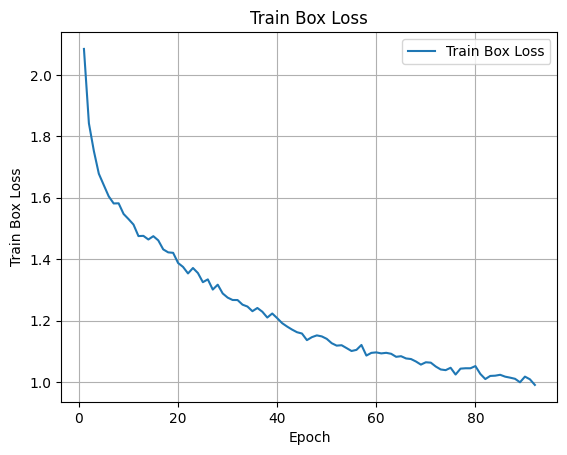

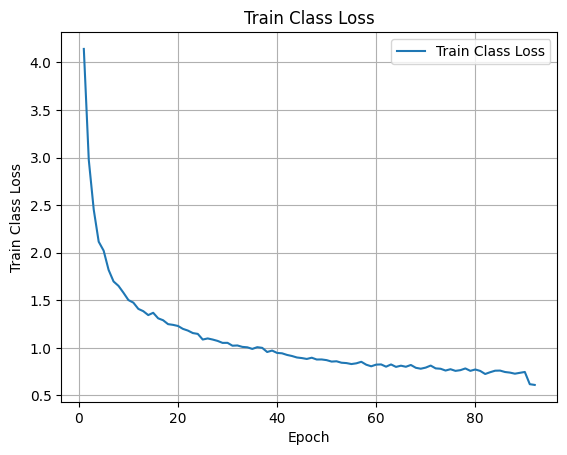

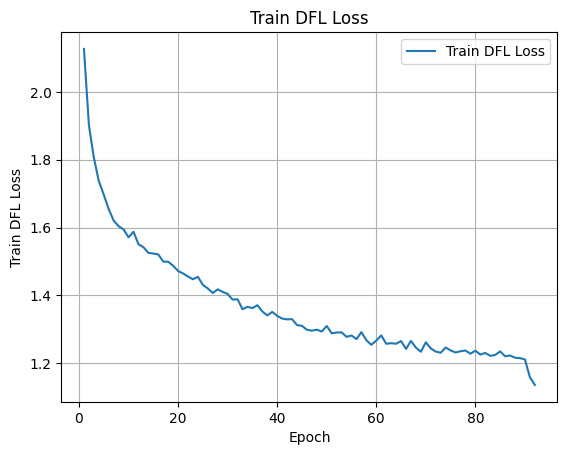

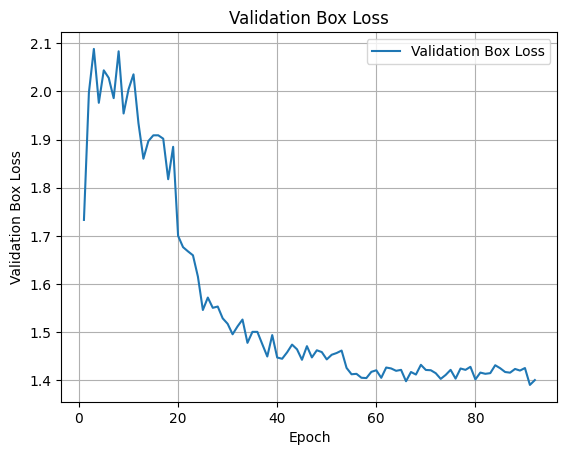

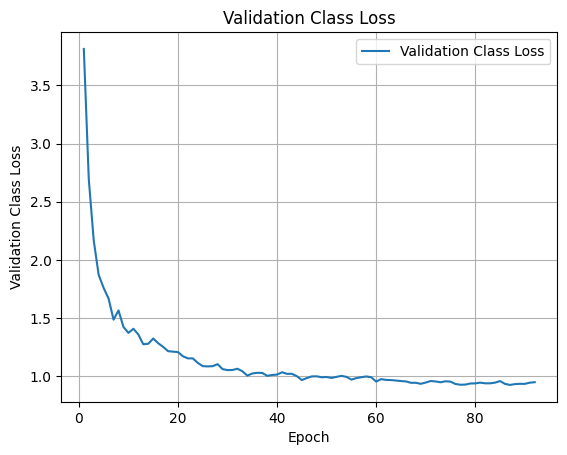

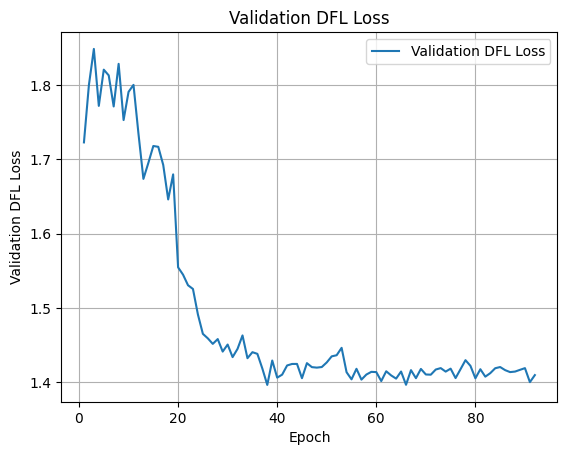

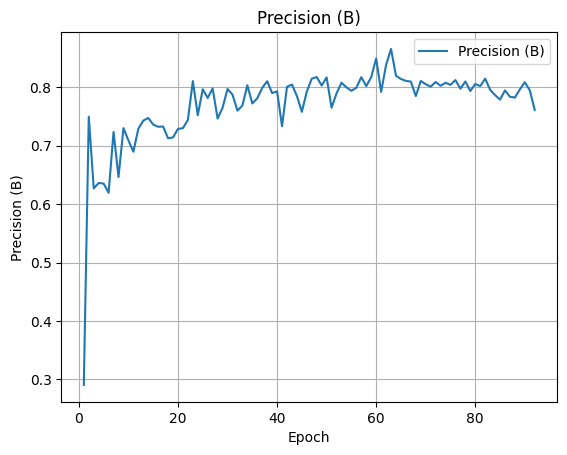

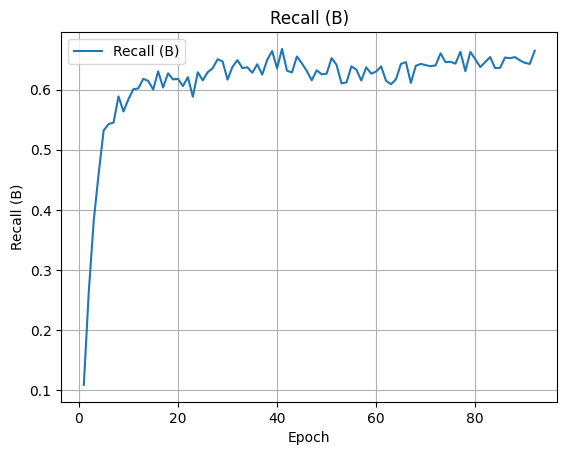

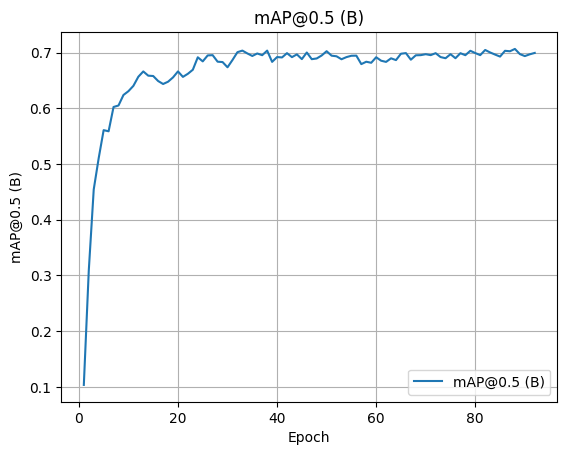

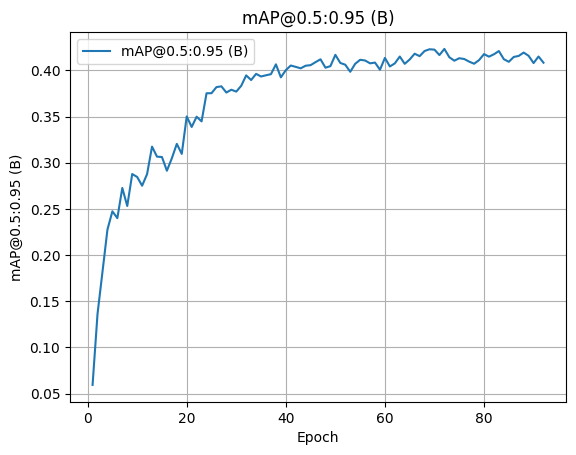


Final Metrics Summary (Last Epoch):
Train Box Loss: 0.9903
Train Class Loss: 0.6098
Train DFL Loss: 1.1357
Validation Box Loss: 1.4007
Validation Class Loss: 0.9485
Validation DFL Loss: 1.4097
Precision (B): 0.7614
Recall (B): 0.6647
mAP@0.5 (B): 0.6996
mAP@0.5:0.95 (B): 0.4083

Improvement Trends:
Train Box Loss: improved (Initial: 2.0846, Final: 0.9903)
Train Class Loss: improved (Initial: 4.1419, Final: 0.6098)
Train DFL Loss: improved (Initial: 2.1270, Final: 1.1357)
Validation Box Loss: improved (Initial: 1.7331, Final: 1.4007)
Validation Class Loss: improved (Initial: 3.8133, Final: 0.9485)
Validation DFL Loss: improved (Initial: 1.7226, Final: 1.4097)
Precision (B): worsened (Initial: 0.2904, Final: 0.7614)
Recall (B): worsened (Initial: 0.1087, Final: 0.6647)
mAP@0.5 (B): worsened (Initial: 0.1035, Final: 0.6996)
mAP@0.5:0.95 (B): worsened (Initial: 0.0594, Final: 0.4083)


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = f"{str(results.save_dir)}/results.csv"  

try:
    result_metrics = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}")
    exit()


metrics = {
    "Train Box Loss": "train/box_loss",
    "Train Class Loss": "train/cls_loss",
    "Train DFL Loss": "train/dfl_loss",
    "Validation Box Loss": "val/box_loss",
    "Validation Class Loss": "val/cls_loss",
    "Validation DFL Loss": "val/dfl_loss",
    "Precision (B)": "metrics/precision(B)",
    "Recall (B)": "metrics/recall(B)",
    "mAP@0.5 (B)": "metrics/mAP50(B)",
    "mAP@0.5:0.95 (B)": "metrics/mAP50-95(B)",
}

%matplotlib inline

available_metrics = {name: col for name, col in metrics.items() if col in result_metrics.columns}
missing_metrics = [name for name in metrics if name not in available_metrics]

if missing_metrics:
    print(f"Missing metrics: {', '.join(missing_metrics)}")
else:
    print("All expected metrics are present.")

for metric_name, col in available_metrics.items():
    plt.figure()
    plt.plot(result_metrics["epoch"], result_metrics[col], label=metric_name)
    plt.title(metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

final_epoch = result_metrics.iloc[-1]
final_metrics = {name: final_epoch[col] for name, col in available_metrics.items()}

print("\nFinal Metrics Summary (Last Epoch):")
for name, value in final_metrics.items():
    print(f"{name}: {value:.4f}")

print("\nImprovement Trends:")
for metric_name, col in available_metrics.items():
    initial = result_metrics[col].iloc[0]
    final = result_metrics[col].iloc[-1]
    trend = "improved" if final < initial else "worsened"
    print(f"{metric_name}: {trend} (Initial: {initial:.4f}, Final: {final:.4f})")
